Epoch 1/10
157/157 [==============================] - 118s 746ms/step - loss: 0.6173 - val_loss: 0.6018
Epoch 2/10
157/157 [==============================] - 116s 739ms/step - loss: 0.6024 - val_loss: 0.6007
Epoch 3/10
157/157 [==============================] - 116s 742ms/step - loss: 0.6005 - val_loss: 0.5980
Epoch 4/10
157/157 [==============================] - 117s 743ms/step - loss: 0.5997 - val_loss: 0.5972
Epoch 5/10
157/157 [==============================] - 117s 747ms/step - loss: 0.5988 - val_loss: 0.5965
Epoch 6/10
157/157 [==============================] - 116s 742ms/step - loss: 0.5984 - val_loss: 0.5971
Epoch 7/10
157/157 [==============================] - 115s 732ms/step - loss: 0.5983 - val_loss: 0.5961
Epoch 8/10
157/157 [==============================] - 116s 737ms/step - loss: 0.5979 - val_loss: 0.5959
Epoch 9/10
157/157 [==============================] - 115s 735ms/step - loss: 0.5977 - val_loss: 0.5963
Epoch 10/10
313/313 [==============================] - 8s 26ms/s

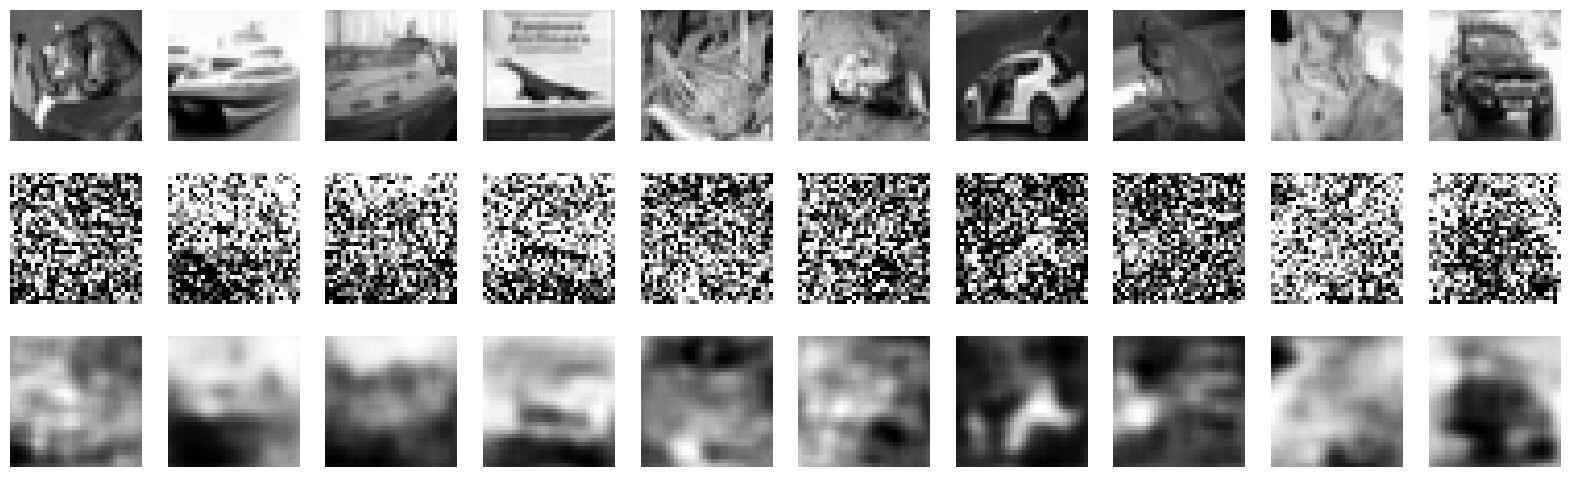

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.transform import resize

# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = cifar10.load_data()

# Normalize the images
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Convert to grayscale and resize
desired_size = (32, 32)
X_train = np.array([resize(rgb2gray(img), desired_size) for img in X_train])
X_test = np.array([resize(rgb2gray(img), desired_size) for img in X_test])

# Add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Split into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

# Add noise to the data
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_val_noisy = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_val_noisy = np.clip(X_val_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

# Build the denoising autoencoder
input_img = Input(shape=(32, 32, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X_train_noisy, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val_noisy, X_val))

# Denoise some test images
denoised_imgs = autoencoder.predict(X_test_noisy)

# Calculate PSNR
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate average PSNR for the test set
psnr_values = [calculate_psnr(X_test[i], denoised_imgs[i]) for i in range(len(X_test))]
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr:.2f} dB")

# Visualize the original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32), cmap='gray')
    ax.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].reshape(32, 32), cmap='gray')
    ax.axis('off')

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_imgs[i].reshape(32, 32), cmap='gray')
    ax.axis('off')
plt.show()
